In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K
from keras.metrics import Metric

In [ ]:
print("Current working directory:", os.getcwd())

Current working directory: /content


# **Mutations**

In [ ]:
def read_fasta_file(file_path, num_sequences=200):
    sequences = []
    with open(file_path, 'r') as file:
        current_sequence = ""
        sequence_count = 0
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Header line
                if current_sequence:
                    sequences.append(current_sequence)
                    current_sequence = ""
                    sequence_count += 1
                    if num_sequences is not None and sequence_count >= num_sequences:
                        break
            else:
                current_sequence += line
        # Append the last sequence
        if current_sequence:
            sequences.append(current_sequence)
    return sequences


In [ ]:
# def read_fasta_file(file_path):
#     sequences = []
#     with open(file_path, 'r') as file:
#         current_sequence = ""
#         for line in file:
#             line = line.strip()
#             if line.startswith('>'):  # Header line
#                 if current_sequence:
#                     sequences.append(current_sequence)
#                     current_sequence = ""
#             else:
#                 current_sequence += line
#         # Append the last sequence
#         if current_sequence:
#             sequences.append(current_sequence)
#     return sequences

In [ ]:
# Read sequences from the FASTA file
HCovHKU1 = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/HCov-HKU1/HCov-HKU1_All.fasta")
HCov229E = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/HCov-229E/HCov-229E_All.fasta")
HCovNL63 = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/HCov-NL63/HCov-NL63_All.fasta")
SARSCoV = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/SARS-CoV/SARS-CoV_All.fasta")
MERSCoV = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/MERS-CoV/MERS-CoV_All.fasta")
SARSCoV2 = read_fasta_file("/content/drive/MyDrive/BI-Project/Datasets/SARS-CoV-2/SARS-CoV-2_All.fasta")

In [ ]:
def convert_sequences_to_uppercase(sequences):
    for index, sequence in enumerate(sequences):
        if not sequence.isupper():
            sequences[index] = sequence.upper()

In [ ]:
convert_sequences_to_uppercase(HCovHKU1)
convert_sequences_to_uppercase(HCov229E)
convert_sequences_to_uppercase(HCovNL63)
convert_sequences_to_uppercase(SARSCoV)
convert_sequences_to_uppercase(MERSCoV)
convert_sequences_to_uppercase(SARSCoV2)

In [ ]:
def replace_invalid_characters(sequences):
    valid_chars = {'A', 'G', 'C', 'T'}
    for index, sequence in enumerate(sequences):
        sequences[index] = ''.join(char if char in valid_chars else 'N' for char in sequence)

In [ ]:
replace_invalid_characters(HCovHKU1)
replace_invalid_characters(HCov229E)
replace_invalid_characters(HCovNL63)
replace_invalid_characters(SARSCoV)
replace_invalid_characters(MERSCoV)
replace_invalid_characters(SARSCoV2)

In [ ]:
def remove_sequences_with_high_n_content(sequences):
    valid_chars = {'A', 'G', 'C', 'T'}
    filtered_sequences = []
    for sequence in sequences:
        n_count = sum(1 for char in sequence if char == 'N')
        sequence_length = len(sequence)
        if n_count / sequence_length <= 0.10:  # Check if N count is less than or equal to 25% of sequence length
            filtered_sequences.append(sequence)
    return filtered_sequences

In [ ]:
HCovHKU1 = remove_sequences_with_high_n_content(HCovHKU1)
HCov229E = remove_sequences_with_high_n_content(HCov229E)
HCovNL63 = remove_sequences_with_high_n_content(HCovNL63)
SARSCoV = remove_sequences_with_high_n_content(SARSCoV)
MERSCoV = remove_sequences_with_high_n_content(MERSCoV)
SARSCoV2 = remove_sequences_with_high_n_content(SARSCoV2)

In [ ]:
def filter_short_sequences(sequences, threshold_length = 27000):
    filtered_sequences = [sequence for sequence in sequences if len(sequence) >= threshold_length]
    return filtered_sequences

In [ ]:
HCovHKU1 = filter_short_sequences(HCovHKU1)
HCov229E = filter_short_sequences(HCov229E)
HCovNL63 = filter_short_sequences(HCovNL63)
SARSCoV = filter_short_sequences(SARSCoV)
MERSCoV = filter_short_sequences(MERSCoV)
SARSCoV2 = filter_short_sequences(SARSCoV2)

In [ ]:
def trim_sequences(sequences):
    trimmed_sequences = []
    for sequence in sequences:
        if len(sequence) > 60:  # Check if sequence length is greater than 40 characters
            trimmed_sequence = sequence[20:-40]  # Remove first 20 and last 20 characters
            trimmed_sequences.append(trimmed_sequence)
        else:
            print(f"Sequence '{sequence}' is too short to trim.")
    return trimmed_sequences

In [ ]:
HCovHKU1 = trim_sequences(HCovHKU1)
HCov229E = trim_sequences(HCov229E)
HCovNL63 = trim_sequences(HCovNL63)
SARSCoV = trim_sequences(SARSCoV)
MERSCoV = trim_sequences(MERSCoV)
SARSCoV2 = trim_sequences(SARSCoV2)

In [ ]:
def trim_sequences_to_length(sequences, target_length=27000, padding_char='N'):
    trimmed_sequences = []
    for sequence in sequences:
        if len(sequence) < target_length:
            padded_sequence = sequence.ljust(target_length, padding_char)
            trimmed_sequences.append(padded_sequence)
        else:
            trimmed_sequences.append(sequence[:target_length])
    return trimmed_sequences

In [ ]:
HCovHKU1 = trim_sequences_to_length(HCovHKU1)
HCov229E = trim_sequences_to_length(HCov229E)
HCovNL63 = trim_sequences_to_length(HCovNL63)
SARSCoV = trim_sequences_to_length(SARSCoV)
MERSCoV = trim_sequences_to_length(MERSCoV)
SARSCoV2 = trim_sequences_to_length(SARSCoV2)

In [ ]:
def encode_sequences(sequences):
    encoding_mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N': 4}
    encoded_sequences = []
    for sequence in sequences:
        encoded_sequence = [encoding_mapping[char] for char in sequence]
        encoded_sequences.append(encoded_sequence)
    return encoded_sequences

In [ ]:
HCovHKU1 = encode_sequences(HCovHKU1)
HCov229E = encode_sequences(HCov229E)
HCovNL63 = encode_sequences(HCovNL63)
SARSCoV = encode_sequences(SARSCoV)
MERSCoV = encode_sequences(MERSCoV)
SARSCoV2 = encode_sequences(SARSCoV2)

In [ ]:
HCovHKU1 = np.array([to_categorical(sequence, num_classes=5) for sequence in HCovHKU1])
HCov229E = np.array([to_categorical(sequence, num_classes=5) for sequence in HCov229E])
HCovNL63 = np.array([to_categorical(sequence, num_classes=5) for sequence in HCovNL63])
SARSCoV = np.array([to_categorical(sequence, num_classes=5) for sequence in SARSCoV])
MERSCoV = np.array([to_categorical(sequence, num_classes=5) for sequence in MERSCoV])
SARSCoV2 = np.array([to_categorical(sequence, num_classes=5) for sequence in SARSCoV2])

# Reference **Seqences**

In [ ]:
def readFile(path: str):
    """
    Read File.

    Parameters:
    path (string): Path of file containing gene sequences.

    Returns:
    Genome Sequences in a array format.

    Prints:
    Length of given sequence.

    """
    file = open(path, 'r')
    # Skip the first line
    first_line_skipped = True

    sequences = []

    # Read and append characters to the array
    for line in file:
        if first_line_skipped:
            first_line_skipped = False
            continue  # Skip the first line
        sequences.extend(line.strip())
    # Print the length of sequences
    print(len(sequences))
    return sequences

In [ ]:
HCov229E_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/HCov-229E/HCov-229E_Ref/ncbi_dataset/data/GCA_000853505.1/GCA_000853505.1_ViralProj14913_genomic.fna')
HCovHKU1_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/HCov-HKU1/HCov-HKU1_Ref/ncbi_dataset/data/GCA_000858765.1/GCA_000858765.1_ViralProj15139_genomic.fna')
HCovNL63_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/HCov-NL63/HCov-NL63_Ref/ncbi_dataset/data/GCA_000853865.1/GCA_000853865.1_ViralProj14960_genomic.fna')
MERSCoV_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/MERS-CoV/MERS-CoV_Ref/ncbi_dataset/data/GCA_000901155.1/GCA_000901155.1_ViralProj183710_genomic.fna')
SARSCoV_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/SARS-CoV/SARS-CoV_Ref/ncbi_dataset/data/GCA_000864885.1/GCA_000864885.1_ViralProj15500_genomic.fna')
SARSCoV2_ref = readFile('/content/drive/MyDrive/BI-Project/Datasets/SARS-CoV-2/SARS-CoV-2_Ref/ncbi_dataset/data/genomic.fna')

27317
29926
27553
30119
29751
29903


In [ ]:
def trim_sequences_ref(sequence):
    if len(sequence) > 60:
        sequence = sequence[20:-40]
    else:
        print(f"Sequence '{sequence}' is too short to trim.")
    return sequence

In [ ]:
HCovHKU1_ref = trim_sequences_ref(HCovHKU1_ref)
HCov229E_ref = trim_sequences_ref(HCov229E_ref)
HCovNL63_ref = trim_sequences_ref(HCovNL63_ref)
SARSCoV_ref = trim_sequences_ref(SARSCoV_ref)
MERSCoV_ref = trim_sequences_ref(MERSCoV_ref)
SARSCoV2_ref = trim_sequences_ref(SARSCoV2_ref)

In [ ]:
def resize_sequence(sequence, length = 27000, padding_char='A'):
    """
    Resize the sequences to given length.

    Parameters:
    sequence : Sequence of a particular genome. eg: ['A','G','C',...]
    length : Desired Length.
    padding_char : If sequence length > desired length, pad with padding char to get higher length.

    Returns:
    Resized sequence of desired length.

    Prints:
    length of output: resized sequence
    """
    if len(sequence) < length:
        # Add padding to the end
        resized_sequence = sequence + list(padding_char * (length - len(sequence)))
    elif len(sequence) > length:
        # Optionally truncate longer sequences
        resized_sequence = sequence[:length]
    else:
        resized_sequence = sequence

    print(len(resized_sequence))
    return resized_sequence

In [ ]:
HCov229E_ref = resize_sequence(HCov229E_ref)
HCovHKU1_ref = resize_sequence(HCovHKU1_ref)
HCovNL63_ref = resize_sequence(HCovNL63_ref)
MERSCoV_ref = resize_sequence(MERSCoV_ref)
SARSCoV_ref = resize_sequence(SARSCoV_ref)
SARSCoV2_ref = resize_sequence(SARSCoV2_ref)

27000
27000
27000
27000
27000
27000


In [ ]:
def integer_encode(sequence):
    """
    Encode character to integer.

    Parameters:
    sequence: Sequence of a particular genome. eg: ['A','G','C',...]

    Returns:
    Encoded array for a sequence.
    """
    encoding = {'A': 0, 'T': 1, 'C': 2, 'G': 3, 'N':4}
    return np.array([encoding[base] for base in sequence])

In [ ]:
HCov229E_ref = integer_encode(HCov229E_ref)
HCovHKU1_ref = integer_encode(HCovHKU1_ref)
HCovNL63_ref = integer_encode(HCovNL63_ref)
MERSCoV_ref = integer_encode(MERSCoV_ref)
SARSCoV_ref = integer_encode(SARSCoV_ref)
SARSCoV2_ref = integer_encode(SARSCoV2_ref)

In [ ]:
HCov229E_ref = np.array(to_categorical(HCov229E_ref, num_classes=5))
HCovHKU1_ref = np.array(to_categorical(HCovHKU1_ref, num_classes=5))
HCovNL63_ref = np.array(to_categorical(HCovNL63_ref, num_classes=5))
MERSCoV_ref = np.array(to_categorical(MERSCoV_ref, num_classes=5))
SARSCoV_ref = np.array(to_categorical(SARSCoV_ref, num_classes=5))
SARSCoV2_ref = np.array(to_categorical(SARSCoV2_ref, num_classes=5))

In [ ]:
X_train = [HCov229E_ref[:] for _ in range(len(HCov229E))] + \
          [HCovHKU1_ref[:] for _ in range(len(HCovHKU1))] + \
          [HCovNL63_ref[:] for _ in range(len(HCovNL63))] + \
          [MERSCoV_ref[:] for _ in range(len(MERSCoV))] + \
          [SARSCoV_ref[:] for _ in range(len(SARSCoV))] + \
          [SARSCoV2_ref[:] for _ in range(len(SARSCoV2))]

In [ ]:
print(np.shape(X_train))

(1019, 27000, 5)


In [ ]:
from itertools import chain

y_train = [*HCovHKU1, *HCov229E, *HCovNL63, *SARSCoV, *MERSCoV, *SARSCoV2]

In [ ]:
print(np.shape(y_train))

(1019, 27000, 5)


In [ ]:
# all_sequences = [SARSCoV, SARSCoV2, MERSCoV, HCov229E, HCovHKU1, HCovNL63]
# original_sequences = [HCov229E,HCovNL63,SARSCoV,HCovHKU1,MERSCoV]
# mutated_sequences = [HCovNL63,SARSCoV,HCovHKU1,MERSCoV,SARSCoV2]

# max_length = max(len(seq) for seq in all_sequences)
# min_length = min(len(seq) for seq in all_sequences)
# length = min_length

# X_train = get_train_data(original_sequences, length)
# y_train = get_train_data(mutated_sequences, length)

In [ ]:
# np.shape(X_train)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train = X_train.astype(int)
y_train = y_train.astype(int)

In [ ]:
# split_index = int(len(X_train) * 0.8)
# X_train, X_test = X_train[:split_index], X_train[split_index:]
# y_train, y_test = y_train[:split_index], y_train[split_index:]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
# X_train.shape[1]

In [ ]:
# y_train.shape

In [ ]:
del HCov229E
del HCov229E_ref
del HCovHKU1
del HCovHKU1_ref
del HCovNL63
del HCovNL63_ref
del MERSCoV
del MERSCoV_ref
del SARSCoV
del SARSCoV_ref
del SARSCoV2
del SARSCoV2_ref
# del split_index


In [ ]:
# for i, array_slice in enumerate(X_train):
#     # Construct the file name
#     file_name = os.path.join("/content/drive/MyDrive/BI-Project/Pre_processed_Dataset", f'X_train_{i}.csv')
#     # Save the slice as a CSV file
#     np.savetxt(file_name, array_slice, delimiter=',')

# for i, array_slice in enumerate(y_train):
#     # Construct the file name
#     file_name = os.path.join("/content/drive/MyDrive/BI-Project/Pre_processed_Dataset", f'y_train_{i}.csv')
#     # Save the slice as a CSV file
#     np.savetxt(file_name, array_slice, delimiter=',')

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(tf.round(y_pred), tf.int32)

        # Calculate confusion matrix components
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), dtype=tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), dtype=tf.float32))

        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

In [ ]:
# Build the Many-to-Many LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.build(input_shape=(None, 27000,5))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy', F1Score()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 27000, 128)        35840     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 27000, 128)        0         
                                                                 
 dense (Dense)               (None, 27000, 64)         8256      
                                                                 
 dropout_1 (Dropout)         (None, 27000, 64)         0         
                                                                 
 dense_1 (Dense)             (None, 27000, 5)          325       
                                                                 
Total params: 44421 (173.52 KB)
Trainable params: 44421 (173.52 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

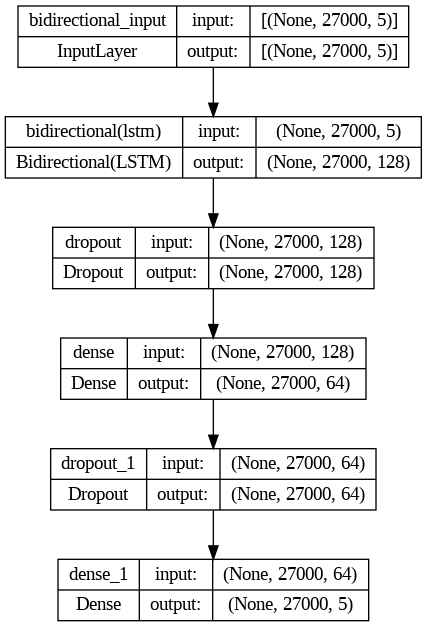

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="model.png")

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/50
41/41 [==============================] - 73s 2s/step - loss: 1.4824 - accuracy: 0.2934 - f1_score: 0.0299 - val_loss: 1.3660 - val_accuracy: 0.3480 - val_f1_score: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 66s 2s/step - loss: 1.3910 - accuracy: 0.3254 - f1_score: 0.0092 - val_loss: 1.3654 - val_accuracy: 0.3480 - val_f1_score: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 64s 2s/step - loss: 1.3782 - accuracy: 0.3356 - f1_score: 4.4260e-05 - val_loss: 1.3657 - val_accuracy: 0.3480 - val_f1_score: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 63s 2s/step - loss: 1.3749 - accuracy: 0.3388 - f1_score: 1.2724e-06 - val_loss: 1.3652 - val_accuracy: 0.3480 - val_f1_score: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 59s 1s/step - loss: 1.3734 - accuracy: 0.3416 - f1_score: 9.0888e-08 - val_loss: 1.3643 - val_accuracy: 0.3480 - val_f1_score: 0.0000e+00
Epoch 6/50
41/41 [==============================] - 63s 2s

In [ ]:
print(history.history.keys())  # Check what keys are available

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


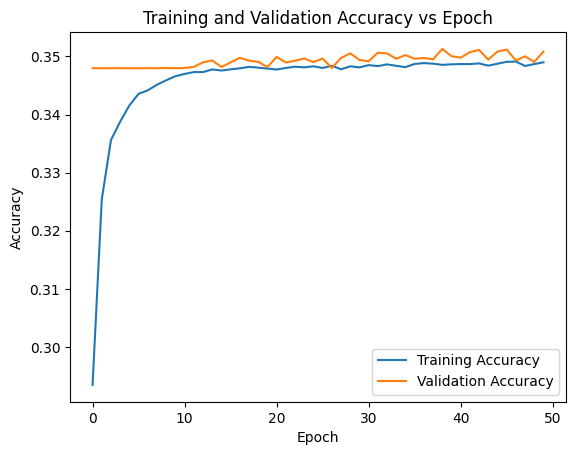

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy vs epoch graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

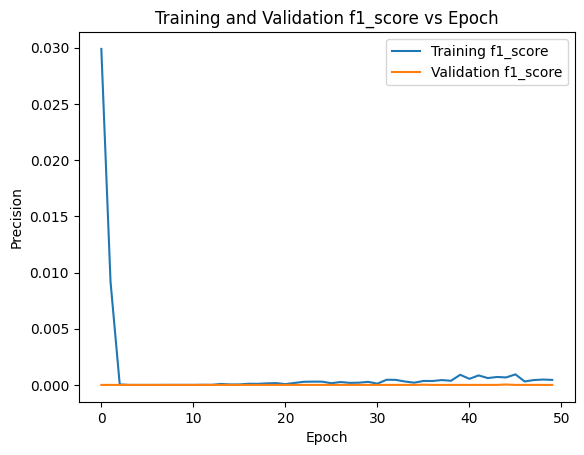

In [ ]:
plt.plot(history.history['f1_score'], label='Training f1_score')
plt.plot(history.history['val_f1_score'], label='Validation f1_score')
plt.title('Training and Validation f1_score vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
# plt.plot(history.history['recall'], label='Training Recall')
# plt.plot(history.history['val_recall'], label='Validation Recall')
# plt.title('Training and Validation Recall vs Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()
# plt.show()

In [ ]:
# loaded_model = tf.keras.models.load_model("MODEL1.h5")

In [ ]:
accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy[1] * 100:.2f}%")

7/7 [==============================] - 5s 684ms/step - loss: 1.3555 - accuracy: 0.3509 - f1_score: 0.0000e+00
Test Accuracy: 35.09%


In [ ]:
del X_test
del X_train
del y_test
del y_train

In [ ]:
def get_train_data(sequences, length = 27000):
    """
    Returns training data after performing resize_sequence, encode and combining all sequences.

    Parameters:
    sequences: Sequences of all original genome or mutated genome.

    Returns:
    X_train or y_train of shape:

    """
    var1 = np.array(to_categorical(integer_encode(resize_sequence(sequences[0], length)), num_classes=5))
    if len(sequences) == 1:
        return [var1[np.newaxis, :]]
    var2 = np.array(to_categorical(integer_encode(resize_sequence(sequences[1], length)), num_classes=5))
    temp = np.concatenate((var1[np.newaxis, :], var2[np.newaxis, :]), axis=0)
    for i in range(2,len(sequences)):
        var = np.array(to_categorical(integer_encode(resize_sequence(sequences[i], length)), num_classes=5))
        temp = np.concatenate((temp, var[np.newaxis, :]), axis=0)
    return temp

In [ ]:
MERSCoV = readFile('/content/drive/MyDrive/BI-Project/Datasets/HCov-HKU1/HCov-HKU1_Ref/ncbi_dataset/data/GCA_000858765.1/GCA_000858765.1_ViralProj15139_genomic.fna')


## Given input sequence for prediction
input_sequence = MERSCoV

# One-hot encode the input sequence
X_input = get_train_data([input_sequence],27000)
# print(np.array(X_input))
# X_input = resize_input(np.array(X_input))



# Predict mutated sequence
predicted_sequence_encoded = model.predict(X_input)

# Decode the predicted sequence from one-hot encoding
base_encoding = {0: 'A', 1: 'T', 2: 'C', 3: 'G', 4:'N'}
# print(predicted_sequence_encoded)
predicted_sequence = ''.join([base_encoding[np.argmax(base)] for base in predicted_sequence_encoded[0]])

# print(f"Original Sequence: {''.join([str(i) for i in input_sequence])}")
# print(f"Predicted Mutated Sequence: {predicted_sequence}")

# Assume input_sequence and predicted_sequence are already defined

# Open a file in write mode
with open("/content/drive/MyDrive/BI-Project/Outputs/HCOVHKU1.txt", "w") as file:
    # Write the original sequence to the file
    file.write(f"Original Sequence: {''.join([str(i) for i in input_sequence])}\n")

    # Write the predicted mutated sequence to the file
    file.write(f"Predicted Mutated Sequence: {predicted_sequence}\n")

print("Sequences saved to HCOV229E.txt")


29926
27000
1/1 [==============================] - 1s 718ms/step
Sequences saved to HCOV229E.txt


In [ ]:
model.save("MODEL1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
